<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Matias Armijo</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [38]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [39]:
import gzip
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Carga de archivo de duracion 32 Segundos
ruta_archivo_comprimido = 'H-H1_GWOSC_16KHZ_R1-1126259447-32.txt.gz'
ruta_archivo_descomprimido = 'GW150914_H1_strain_32_sec.txt'

with gzip.open(ruta_archivo_comprimido, 'rb') as archivo_comprimido:
   with open(ruta_archivo_descomprimido,'wb') as archivo_descomprimido:
           shutil.copyfileobj(archivo_comprimido, archivo_descomprimido)

# Lectura de .txt del archivo descomprimido
ruta_H1_32 = "GW150914_H1_strain_32_sec.txt"

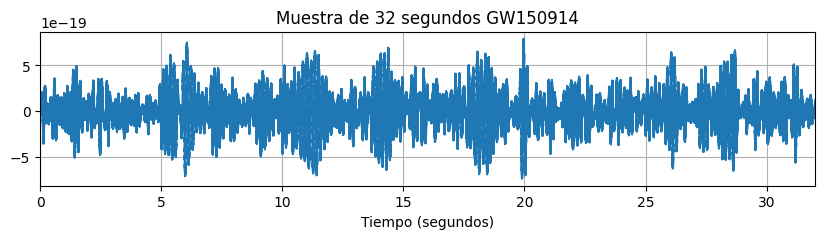

In [40]:
fs = 16384     # Tasa de muestreo según archivo .txt
duration = 32  # Duracion de la medicion GW150914

# Vector de tiempo para la medicion completa de 32 segundos
time = np.linspace(0,duration,duration*fs)

# Carga de datos en la variable "strain"
strain = np.loadtxt(ruta_H1_32, delimiter = ',', skiprows = 1, dtype=float)

# Grafico de la medicion de 32 segundos (GW150914)
plt.figure(figsize=(10,2))
plt.plot(time,strain)
plt.xlabel("Tiempo (segundos)")
plt.title('Muestra de 32 segundos GW150914')
plt.xlim(min(time),max(time))
plt.grid()
plt.show()

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

8


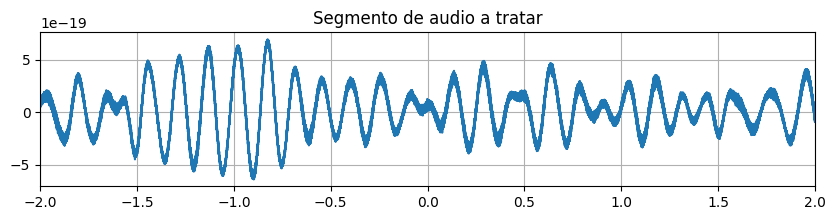

In [41]:
from IPython.display import Audio

# funcion de egmentacion de la muestra de 32 segundos, en largos de 4 segundos con overlap
def slice(x,slice_length,overlap,spacing):
    num_samples = len(x)
    step = slice_length - overlap * 2  # Paso entre segmentos

    fragments = []
    start = 0
    while start < num_samples:
        end = min(start + slice_length, num_samples)
        fragment = x[start:end]
        fragments.append(fragment)
        start += step + spacing
    return fragments       

# Duracion de cada segmento
slice_length = 4*fs

# Creacion de los segmentos en la variables "slices"
slices = slice(strain,slice_length,overlap=slice_length//5,spacing=2*fs)
print(len(slices))

# Eleccion del segmento a tratar
chunk = slices[3]

# Vector de tiempo de 4 segundos
time_4s = np.linspace(-2,2,slice_length)

plt.figure(figsize=(10,2))
plt.plot(time_4s,chunk)
plt.xlim(min(time_4s),max(time_4s))
plt.title('Segmento de audio a tratar')
plt.grid(True)
plt.show()

# Reproduccion del segmento sin ningun tratamiento (normalizado)
Audio(chunk/max(chunk),rate=fs)

## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


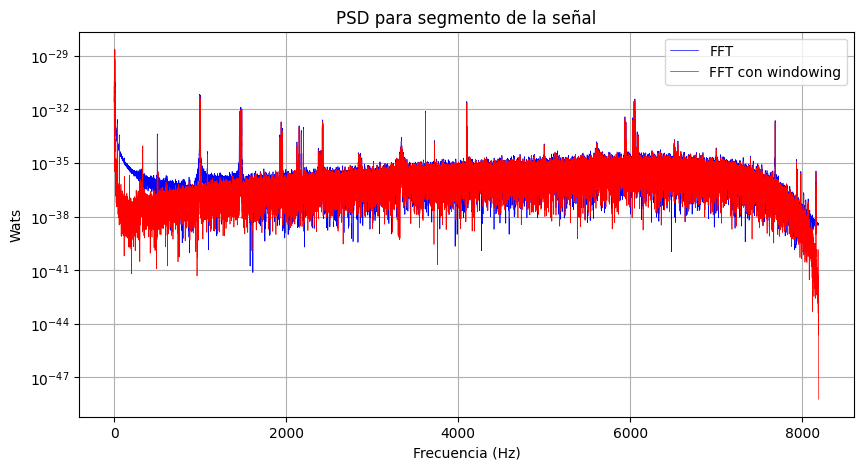

In [42]:
from scipy.fft import fft,ifft,fftfreq
from scipy.signal.windows import tukey

# FFT del segmento "chunk"
chunk_fft = fft(chunk)
frecs = fftfreq(len(chunk),1/fs)

# Windowing utilizando la ventana "tukey"
w = tukey(len(chunk),alpha=0.25)
chunk_fft_windowed = fft(chunk*w)

# PSD de la señal sin "windowing"
pdyf=np.abs(chunk_fft[1:len(chunk)//2])**2 

# PSD de la señal con "windowing"
pdywf=np.abs(chunk_fft_windowed[1:len(chunk)//2])**2 


# Graficas de las PSD segun cada caso
plt.figure(figsize=(10,5))
plt.semilogy(frecs[1:len(chunk)//2], pdyf, '-b',linewidth=.5)
plt.semilogy(frecs[1:len(chunk)//2],  pdywf, '-r',linewidth=.5)
plt.legend(['FFT', 'FFT con windowing'])
plt.title('PSD para segmento de la señal')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Wats')
plt.grid()
plt.show()

## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


/home/matias/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/matias/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


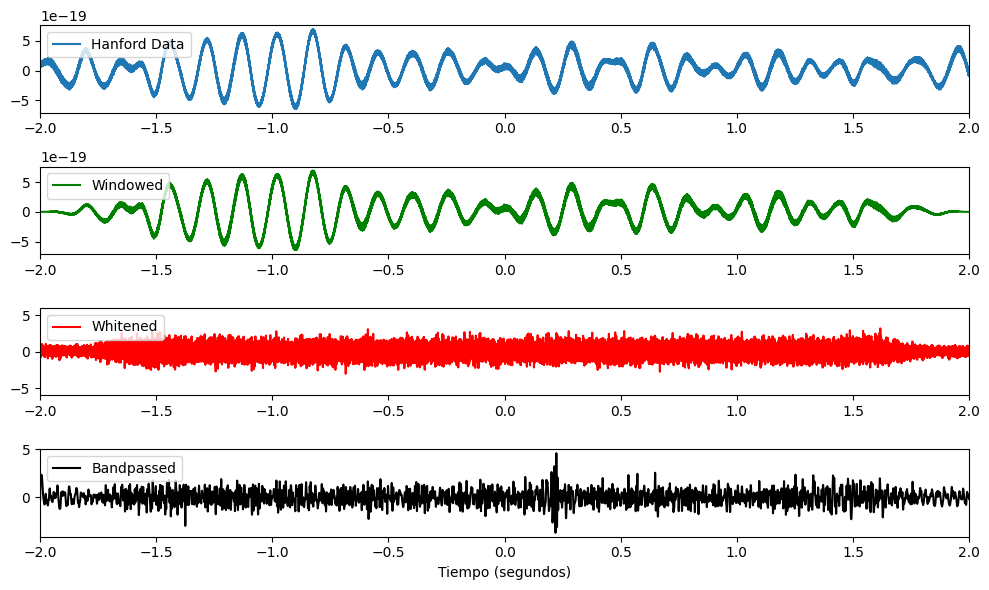

In [43]:
from scipy.signal import welch, butter, lfilter, sosfiltfilt


# Estimacion de la densidad espectral de potencia del ruido
frequencies, psd = welch(strain,fs=fs,nperseg=slice_length,scaling='density',window='tukey',average='mean')

# Blanqueamiento de la señal (Whitened signal)
whitened_signal = ifft(chunk_fft_windowed[0:len(chunk_fft_windowed)//2+1]/np.sqrt(psd))
whitened_signal /= np.std(whitened_signal)

# Funcion filtro pasa banda Butterworth de 8vo orden segun fercuencias de corte
def passband_filter(signal,order,lowcut,highcut,fs):
    # Normalizar las frecuencias de corte con respecto a la frecuencia de muestreo
    low = lowcut / (0.5 * fs)
    high = highcut / (0.5 * fs)
    # Diseñar el filtro Butterworth pasa banda
    sos = butter(order, [low, high], btype='band',output='sos')
    # Aplicar el filtro a la señal
    filtered_signal = sosfiltfilt(sos, signal)
    return filtered_signal

# Aplicacion del filtro pasa banda y escalamiento de datos (varianza unitaria)
filtered_signal = passband_filter(whitened_signal,8,35,450,fs)
filtered_signal /= np.std(filtered_signal)


# Vector de muestras reducido (debido a la aplicacion de la FFT)
time2 = np.linspace(-2,2,len(filtered_signal))

# Graficos del todo el proceso
plt.figure(figsize=(10,6))
plt.subplot(4,1,1)
plt.plot(time_4s,chunk,label='Hanford Data',)
plt.xlim(min(time_4s),max(time_4s))
plt.legend(loc='upper left')
plt.subplot(4,1,2)
plt.plot(time_4s,chunk*w,label='Windowed',color='green')
plt.xlim(min(time_4s),max(time_4s))
plt.legend(loc='upper left')
plt.subplot(4,1,3)
plt.plot(time2,whitened_signal,label='Whitened',color='red')
plt.xlim(min(time_4s),max(time_4s))
plt.ylim(-6,6)
plt.legend(loc='upper left')
plt.subplot(4,1,4)
plt.xlim(min(time_4s),max(time_4s))
plt.plot(time2,filtered_signal, label='Bandpassed',color='black')
plt.legend(loc='upper left')
plt.xlabel('Tiempo (segundos)')

plt.tight_layout()
plt.show()

# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

/home/matias/.local/lib/python3.10/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


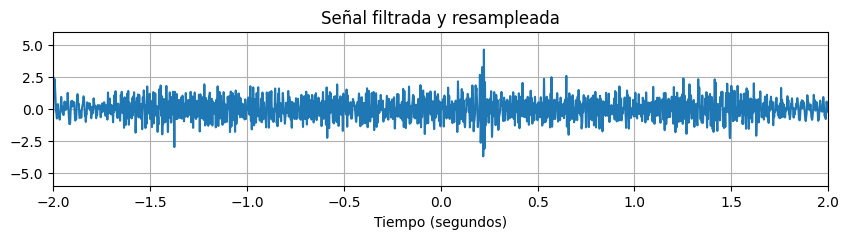

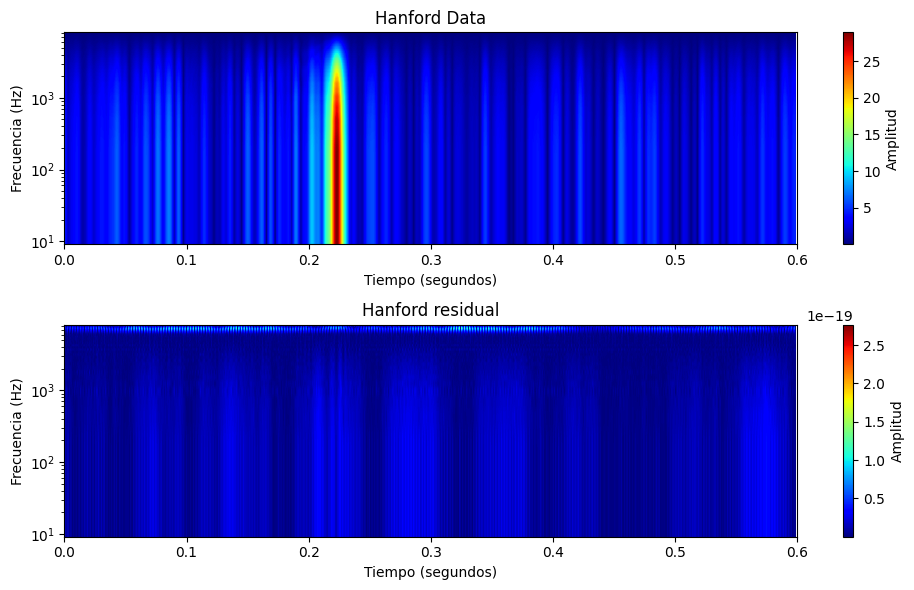

/home/matias/.local/lib/python3.10/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [44]:
from scipy import signal
import pywt

# Resampleo de la señal segun la cantidad de muestras original del segmento
resampled_signal = signal.resample(filtered_signal,4*fs)

# Grafico de la señal resampleada
plt.figure(figsize=(10,2))
plt.plot(time_4s,resampled_signal)
plt.xlim(min(time_4s),max(time_4s))
plt.grid(True)
plt.ylim(-6,6)
plt.xlabel('Tiempo (segundos)')
plt.title('Señal filtrada y resampleada')

# Calcula la transformada wavelet usando la función "cwt" de pywavelets
widths = np.arange(1, 31)  # Anchuras de las wavelets
cwtmatr, freqs = pywt.cwt(resampled_signal,widths, 'fbsp')  # 'mexh' es la familia de wavelets

# Convierte las muestras de tiempo a segundos
# Convierte las frecuencias centrales de las wavelets a frecuencias en Hertz
# Utiliza la fórmula: frecuencia_en_hz = frecuencia_central * (frecuencia_de_muestreo / ancho_de_wavelet)
freqs_hz = freqs * (fs / widths)

# Escalograma visualizando la onda gravitacional
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.imshow(np.abs(cwtmatr), extent=[time_4s[0], time_4s[-1], freqs_hz[-1], freqs_hz[0]], aspect='auto', cmap='jet')
plt.colorbar(label='Amplitud')
plt.xlabel('Tiempo (segundos)')
plt.xlim(0,0.6)
plt.ylabel('Frecuencia (Hz)')
plt.yscale('log')
plt.title('Hanford Data')

# Transformada wavelete para las componentes residuales de la medicion
cwtmatr_2, freqs = pywt.cwt(chunk,widths, 'mexh')  # 'mexh' es la familia de wavelets

# Escalograma residual
plt.subplot(2,1,2)
plt.imshow(np.abs(cwtmatr_2), extent=[time_4s[0], time_4s[-1], freqs_hz[-1], freqs_hz[0]], aspect='auto', cmap='jet')
plt.colorbar(label='Amplitud')
plt.xlabel('Tiempo (segundos)')
plt.xlim(0,0.6)
plt.ylabel('Frecuencia (Hz)')
plt.yscale('log')
plt.title('Hanford residual')

plt.tight_layout()
plt.show()

# Reproduccion de la señal de audio despues del tratamiento 
Audio(resampled_signal/max(resampled_signal),rate=fs)